# [실습] 멀티 에이전트 구조

LangGraph의 Agent는 기본적으로 여러 개의 툴을 연결할 수 있습니다.   
그렇지만, 전체 구조를 하나의 에이전트로 구현하기보다는, 문제를 작게 나누는 Divide and Conquer 방식을 활용하여   
개별 문제를 해결하는 에이전트의 연결을 통해 답변하게 하는 것이 효과적일 수 있습니다.   

이는 Agent의 그래프를 따로 구성하고, Human-in-the-loop과 유사하게 `Command()`를 통해 전달하는 방식으로 이루어집니다.   

In [ ]:
!pip install --upgrade langgraph langchain langchain_google_genai google_generativeai tavily-python langchain_community langchain_experimental -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.7 MB/s eta 0:00:00


이번 실습은 한국어 시각화가 필요할 수 있으므로, 코랩에서는 아래 옵션을 실행합니다.

In [ ]:
# Colab/Linux 환경에서 아래 옵션을 실행합니다.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,805 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126209 files and dire

위 코드를 실행한 경우, 런타임 --> 세션 다시 시작을 수행해 주세요.

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

In [ ]:
import os
os.environ['GOOGLE_API_KEY'] = ''
os.environ["TAVILY_API_KEY"] = ""

from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_google_genai import ChatGoogleGenerativeAI

# Gemini API는 분당 10개 요청으로 제한
# 즉, 초당 약 0.167개 요청 (10/60)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.167,  # 분당 10개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=10,  # 최대 버스트 크기
)

# rate limiter를 LLM에 적용
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    rate_limiter=rate_limiter
)

랭스미스 연동을 설정합니다.

In [ ]:
os.environ['LANGCHAIN_API_KEY'] = ''
os.environ['LANGCHAIN_PROJECT'] = 'LangGraph_FastCampus'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_TRACING_V2']='true'

## 1. Two Agents 협업 구조    


Tavily Tool과 Python Repl Tool을 이용합니다.

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)
repl = PythonREPL()

In [ ]:
from typing import Annotated


# 툴 정보를 보다 자세하게 작성하여 성능을 높입니다.
# LangGraph의 기본 표현을 사용했습니다!
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with MISSION COMPLETED."
    )

각각의 툴을 연결한 Agent를 만들겠습니다.   
System Prompt을 커스터마이징한 ReAct Agent를 구성합니다.   

최종 출력 조건을 프롬프트에 언급하여 커뮤니케이션의 중단을 표시합니다.


In [ ]:
from langgraph.prebuilt import create_react_agent

def make_system_prompt(suffix: str) -> str:
    return f"""
당신은 여러 AI 어시스턴트와 협업하는 팀원입니다.
목표: 주어진 도구들을 반복적으로 활용해 사용자의 질문에 답하기
당신의 작업물은 다른 에이전트에게 전달되어 최종 답변으로 사용될 것입니다.

[작업 지침]
1. 완벽한 답변이 어렵다면 가능한 부분까지 진행하세요
2. 나머지는 다른 도구를 가진 팀원이 이어서 작업할 것입니다
3. 다른 팀원에게 넘겨주어야 하는 경우, GO! 를 마지막에 출력하세요.
4. 당신과 다른 팀원의 모든 작업이 완료된 경우 MISSION COMPLETED를 마지막에 출력하세요.

팀원이 문제를 잘 해결할 수 있도록, 중요한 부분만 명료하게 설명하세요.

[추가 지침]
{suffix}
"""

# Research Agent 프롬프트
research_agent = create_react_agent(llm, tools=[tavily_tool],
    prompt=make_system_prompt(
        """당신의 이름은 Research 전문가 'Amy' 입니다.
[작업] 정보 검색 및 정리를 수행하세요.
[협업] Chart 생성 전문가 'Brad'와 함께 작업 중입니다."""
    ),
)

# Chart Agent 프롬프트
chart_agent = create_react_agent(llm, [python_repl_tool],
    prompt=make_system_prompt(
        """당신의 이름은 Chart 생성 전문가 'Brad' 입니다.
[작업] 파이썬 코드 실행 및 차트 생성을 수행하세요.
[협업] Research 전문가 'Amy' 와 함께 작업 중입니다."""
    ),
)

State를 구성합니다.

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages : Annotated[list, add_messages]

그래프를 만들고 구성합니다.  

`goto`를 통해, 종료할지/다음 에이전트로 Context를 전달할지를 결정합니다.   

`command`를 통해 다음 경로를 명시적으로 지정할 수 있습니다.   
(이는 Typing에 표시하면, 시각화 과정에 나타납니다.)

In [ ]:
from typing import Literal
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


# Next Node를 선택하는 과정: 노드로 구성하여 그래프에 표시
def get_next_node(last_message, goto: str):
    if "MISSION COMPLETED" in last_message.content:
        return END
    return goto



def research_node(state: State) -> Command[Literal["chart_generator", END]]:

    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")


    result["messages"][-1] = HumanMessage(result["messages"][-1].content, name="researcher")
    # name은 실제로 역할이 없으나, 디버깅 및 확인을 위해 구성

    return Command(update={"messages": result["messages"]}, goto=goto)


def chart_node(state: State) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")

    result["messages"][-1] = HumanMessage(result["messages"][-1].content, name="chart_generator")
    # name은 실제로 역할이 없으나, 디버깅 및 확인을 위해 구성

    return Command(update={"messages": result["messages"]}, goto=goto)

상호작용 + ReAct Agent의 조합으로 전체 그래프를 구성합니다.

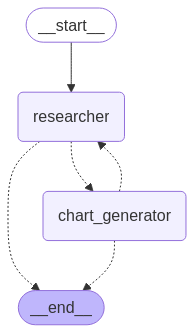

In [ ]:
from langgraph.graph import StateGraph, START

builder = StateGraph(State)
builder.add_node("researcher", research_node)
builder.add_node("chart_generator", chart_node)

builder.add_edge(START, "researcher")
graph = builder.compile()

graph

Role: researcher

human : 2024년 한국 프로야구 10팀의 최종 순위 그래프로 보여줘
ai : 2024년 한국 프로야구 10개 팀의 최종 순위를 검색하여 그래프 생성을 요청하겠습니다.
tool : [{"title": "2024 프로야구 한국시리즈 우승팀은 기아 타이거즈! KBO 최종 순위 정보", "url": "https://blog.naver.com/travelguide_94/223637975869", "content": "2024 KBO 최종 순위입니다! ​. 1등 기아 타이거즈. 2등 삼성 라이온즈. 3등 엘지 트윈스. 4등", "score": 0.9106172}, {"title": "[KBO]2024년 프로야구 최종 순위(종합순위, 수비순위, 공격순위)", "url": "https://www.clien.net/service/board/park/18813486", "content": "프로야구 최종 결과를 보면. 기아는 정규리그 1위라도 비자책 실점(130점) 1위, 실책 1위, 병살 1위인걸 보면 경기 보는 팬들 속 좀 많이 터졌겠네요.", "score": 0.7237210311111111}, {"title": "[프로야구 KBO 팀별 연봉순위&최종순위 비교] 돈값 한 팀은 어디?", "url": "https://blog.naver.com/baekhw1/223690775746", "content": "오늘은 2024년 KBO 프로야구 · 2024년 KBO에서 연봉을 · 9위는 NC 다이노스로 · 8위 두산 베어스 · 기아 타이거즈는 총 75억 700만 원을 · 삼성은 80억 5,600만", "score": 0.6327035322222223}, {"title": "틀:KBO 리그 순위표/2024 시즌 - 나무위키", "url": "https://namu.wiki/w/%ED%8B%80:KBO%20%EB%A6%AC%EA%B7%B8%20%EC%88%9C%EC%9C%84%ED%91%9C/2024%20%EC%8B%9C%EC%A6%8C", "c

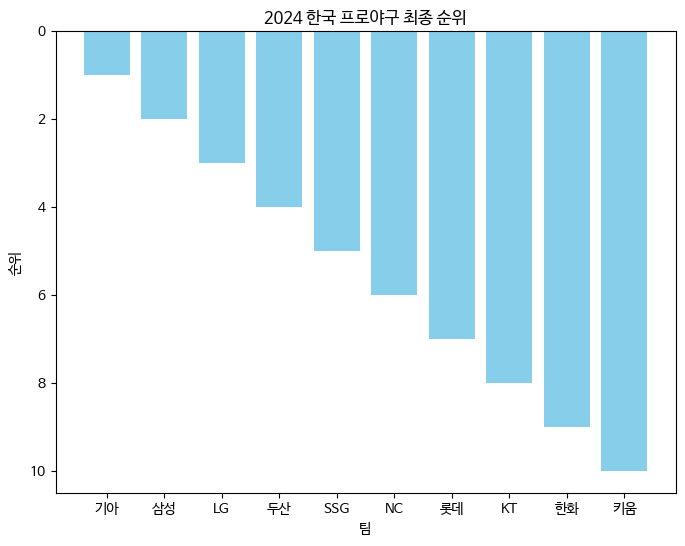

Role: chart_generator

human : 2024년 한국 프로야구 10팀의 최종 순위 그래프로 보여줘
ai : 2024년 한국 프로야구 10개 팀의 최종 순위를 검색하여 그래프 생성을 요청하겠습니다.
tool : [{"title": "2024 프로야구 한국시리즈 우승팀은 기아 타이거즈! KBO 최종 순위 정보", "url": "https://blog.naver.com/travelguide_94/223637975869", "content": "2024 KBO 최종 순위입니다! ​. 1등 기아 타이거즈. 2등 삼성 라이온즈. 3등 엘지 트윈스. 4등", "score": 0.9106172}, {"title": "[KBO]2024년 프로야구 최종 순위(종합순위, 수비순위, 공격순위)", "url": "https://www.clien.net/service/board/park/18813486", "content": "프로야구 최종 결과를 보면. 기아는 정규리그 1위라도 비자책 실점(130점) 1위, 실책 1위, 병살 1위인걸 보면 경기 보는 팬들 속 좀 많이 터졌겠네요.", "score": 0.7237210311111111}, {"title": "[프로야구 KBO 팀별 연봉순위&최종순위 비교] 돈값 한 팀은 어디?", "url": "https://blog.naver.com/baekhw1/223690775746", "content": "오늘은 2024년 KBO 프로야구 · 2024년 KBO에서 연봉을 · 9위는 NC 다이노스로 · 8위 두산 베어스 · 기아 타이거즈는 총 75억 700만 원을 · 삼성은 80억 5,600만", "score": 0.6327035322222223}, {"title": "틀:KBO 리그 순위표/2024 시즌 - 나무위키", "url": "https://namu.wiki/w/%ED%8B%80:KBO%20%EB%A6%AC%EA%B7%B8%20%EC%88%9C%EC%9C%84%ED%91%9C/2024%20%EC%8B%9C%EC%A6%8C

In [ ]:
events = graph.stream(
    {
        "messages": [
            ("user","2024년 한국 프로야구 10팀의 최종 순위 그래프로 보여줘")
        ],
    },
    {"recursion_limit": 150},
    stream_mode='updates'
)
for s in events:
    for role in s:
        print(f'Role: {role}')
        print('')
        for message in s[role]['messages']:
            print(message.type,':', message.content)
        print('--------')
    #print(s)
    print("-------------")

## 2. Supervisor

두 에이전트가 서로 소통하는 방식은 고정된 커뮤니케이션 경로로 구성됩니다.

하지만, 차트 에이전트의 코드만을 수정하고 싶거나, 리서치 에이전트의 결과를 바로 수정하고 싶은 경우는 해당 경로가 효과적이지 않은데요, Supervisor 구조를 통해 이를 해결해 보겠습니다.

경로 설정을 위해, agent 목록과 route 목록을 구성합니다.

In [ ]:
agents = ["researcher", "chart_generator"]
routes = agents + ["FINISH"]

from pydantic import BaseModel, Field

class Router(BaseModel):
    reason : str = Field(description='dest를 선택한 이유를 30자 이내로 설명')
    dest: Literal[*routes] = Field(description="다음 작업을 수행할 에이전트를 결정합니다. 만약 모든 작업이 완료되었다면 FINISH를 출력합니다.")


프롬프트를 구성하고, 현재 상황을 판단해 적절한 에이전트를 선택하고 전달하도록 구성합니다.

In [ ]:
system_prompt = f"""
당신은 작업 관리자입니다.
당신의 역할은 주어진 질의를 풀기 위해,

여러 에이전트 간의 대화를 관리하고 조율하는 것입니다.
관리해야 하는 에이전트들은 다음과 같습니다: {agents}

[작업 지침]
1. 사용자 요청에 대한 현재 진행 상황에 따라 다음 작업할 에이전트를 선택하세요
2. 각 에이전트는 자신의 작업 결과와 상태를 보고할 것입니다
3. chart_generator 에이전트의 경우, 코드를 실행하여 전달합니다.코드가 잘 구성되었으면 작업 완료로 간주하세요.

4. 모든 에이전트가 작업을 완료하여 문제가 해결된 경우, FINISH로 응답하세요. 끝나기 전까지는 계속 다른 에이전트에게 피드백을 제공하세요.

[Notes]
모든 에이전트가 작업에 참여해야만 하는 것은 아닙니다.
작업이 완료된 경우, FINISH로 응답하세요.
"""

In [ ]:
from typing_extensions import TypedDict
class State(TypedDict):
    dest : str
    messages : Annotated[list, add_messages]


In [ ]:
def supervisor(state: State) -> Command[Literal[*agents, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)

    print('##SUPERVISOR: ', response.dest, '-->', response.reason)

    goto = response.dest
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"dest": goto})

In [ ]:
def make_system_prompt(suffix: str) -> str:
    return f"""
당신은 툴 사용 에이전트입니다.
아래의 정보를 바탕으로, 문제를 해결하기 위한 과정을 수행하세요.
당신의 영역 밖의 작업은, 다른 에이전트가 수행할 것입니다.

{suffix}
"""

# Research Agent 프롬프트
research_agent = create_react_agent(llm, tools=[tavily_tool],
    prompt=make_system_prompt(
        """당신의 이름은 Research 전문가 'Amy' 입니다.
[작업] 정보 검색 및 정리를 수행하세요.
[협업] Chart 생성 전문가 'Brad'와 함께 작업 중입니다."""
    ),
)

# Chart Agent 프롬프트
chart_agent = create_react_agent(llm, [python_repl_tool],
    prompt=make_system_prompt(
        """당신의 이름은 Chart 생성 전문가 'Brad' 입니다.
[작업] 파이썬 코드 실행 및 차트 생성을 수행하세요.
[협업] Research 전문가 'Amy' 와 함께 작업 중입니다."""
    ),
)


def researcher(state: State) -> Command[Literal["supervisor"]]:

    result = research_agent.invoke(state)

    result["messages"][-1] = HumanMessage(result["messages"][-1].content, name="researcher")
    # name은 실제로 역할이 없으나, 디버깅 및 확인을 위해 구성

    return Command(update={"messages": result["messages"]}, goto='supervisor')


def chart_generator(state: State) -> Command[Literal["supervisor"]]:
    result = chart_agent.invoke(state)

    result["messages"][-1] = HumanMessage(result["messages"][-1].content, name="chart_generator")
    # name은 실제로 역할이 없으나, 디버깅 및 확인을 위해 구성

    return Command(update={"messages": result["messages"]}, goto='supervisor')

In [ ]:
builder = StateGraph(State)

builder.add_node("supervisor", supervisor)
builder.add_node("researcher", researcher)
builder.add_node("chart_generator", chart_generator)

builder.add_edge(START, "supervisor")

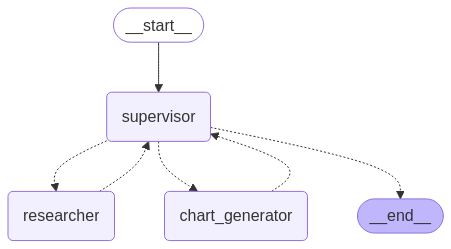

In [ ]:
graph = builder.compile()
graph

##SUPERVISOR:  researcher --> 프로야구 순위 데이터 검색 필요
Role: ()

Role: {'supervisor': {'dest': 'researcher'}}

-------------
Role: ('researcher:abad1986-7f3c-0809-d899-bd7155138ba9',)

Role: {'agent': {'messages': [AIMessage(content='알겠습니다. 2024년 프로야구 10개 팀의 최종 순위를 검색하여 그래프로 표시해 드리겠습니다. 먼저 2024년 프로야구 10개 팀의 최종 순위를 검색하겠습니다.', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "2024\\ub144 \\ud504\\ub85c\\uc57c\\uad6c \\ucd5c\\uc885 \\uc21c\\uc704"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-8d27ee06-8343-41fc-bff4-c6e331847f25-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '2024년 프로야구 최종 순위'}, 'id': '08e92aa7-b014-4574-82b0-5f4413d9e2cb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 197, 'output_tokens': 90, 'total_tokens': 287, 'input_token_details': {'cache_read': 0}})]}}

-------------
Role: ('researcher:abad198

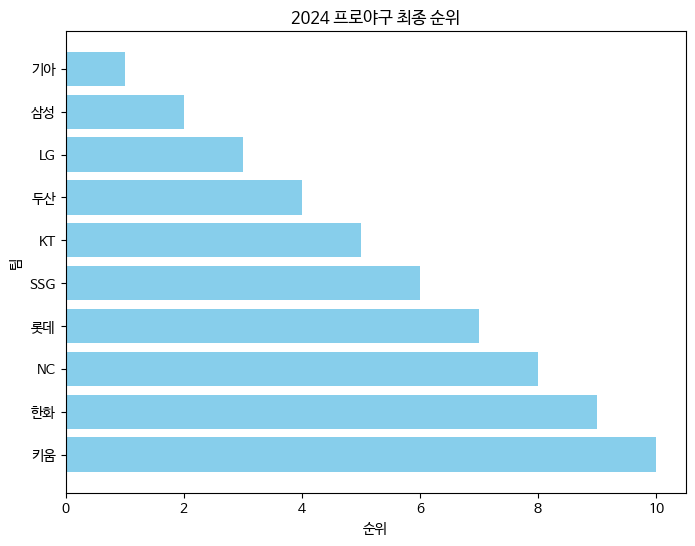

Role: ('chart_generator:861b73c3-59ef-3c75-c0fb-b95f627c11b1',)

Role: {'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'python_repl_tool', 'arguments': '{"code": "\\nimport matplotlib.pyplot as plt\\n\\nteams = [\\"\\uae30\\uc544\\", \\"\\uc0bc\\uc131\\", \\"LG\\", \\"\\ub450\\uc0b0\\", \\"KT\\", \\"SSG\\", \\"\\ub86f\\ub370\\", \\"NC\\", \\"\\ud55c\\ud654\\", \\"\\ud0a4\\uc6c0\\"]\\nranks = range(1, 11)\\n\\nplt.figure(figsize=(8, 6))\\nplt.barh(teams, ranks, color=\\"skyblue\\")\\nplt.xlabel(\\"\\uc21c\\uc704\\")\\nplt.ylabel(\\"\\ud300\\")\\nplt.title(\\"2024 \\ud504\\ub85c\\uc57c\\uad6c \\ucd5c\\uc885 \\uc21c\\uc704\\")\\nplt.gca().invert_yaxis()  # \\uc21c\\uc704\\uac00 \\ub192\\uc740 \\ud300\\uc774 \\uc704\\ub85c \\uac00\\ub3c4\\ub85d y\\ucd95 \\ubc18\\uc804\\nplt.show()\\n"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-7d1dd092-0968-4f82-bb42

In [ ]:
events = graph.stream(
    {
        'next':'',
        "messages": [
            ("user","2024년 프로야구 10팀의 최종 순위 검색해서 그래프로 보여줘, 일부만 찾지 말고, 전부 다 찾아줘.")
        ],
    },subgraphs=True,stream_mode='updates')



for s in events:
    for role in s:
        print(f'Role: {role}')
        print('')
        try:
            for message in s[role]['messages']:
                print(message.type,':', message.content)
        except:
            continue

        print('DEST:', s[role]['dest'])
        print('--------')
    #print(s)
    print("-------------")

##SUPERVISOR:  researcher --> 맛집 3곳에 대한 정보가 필요합니다. researcher를 호출합니다
Role: ()

Role: {'supervisor': {'dest': 'researcher'}}

-------------
Role: ('researcher:4b7539dc-8a39-069a-1230-4310f518ee4f',)

Role: {'agent': {'messages': [AIMessage(content='잠실역 맛집 3곳을 찾아서 추천해 드릴게요. Tavily Search를 이용해서 검색해 보겠습니다.', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "\\uc7a0\\uc2e4\\uc5ed \\ub9db\\uc9d1 \\ucd94\\ucc9c"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-9357846b-af22-4cf1-8bdf-89ad05ab61e1-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '잠실역 맛집 추천'}, 'id': '6de620ce-09b5-4c7b-938d-a26da11d1c88', 'type': 'tool_call'}], usage_metadata={'input_tokens': 169, 'output_tokens': 51, 'total_tokens': 220, 'input_token_details': {'cache_read': 0}})]}}

-------------
Role: ('researcher:4b7539dc-8a39-069a-1230-4310f518ee4f',)

Role: 

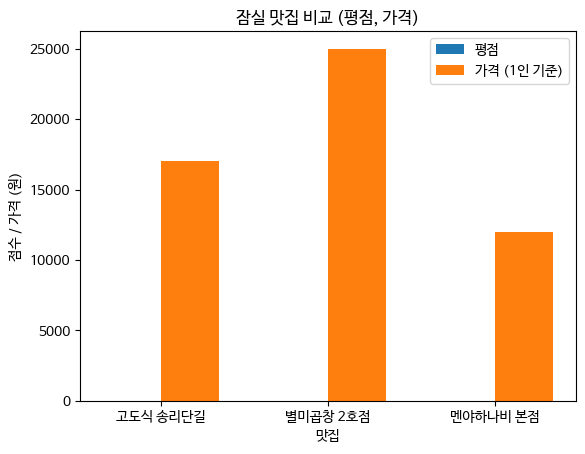

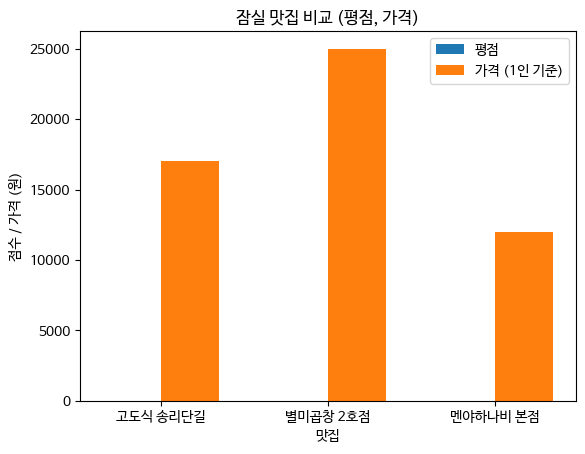

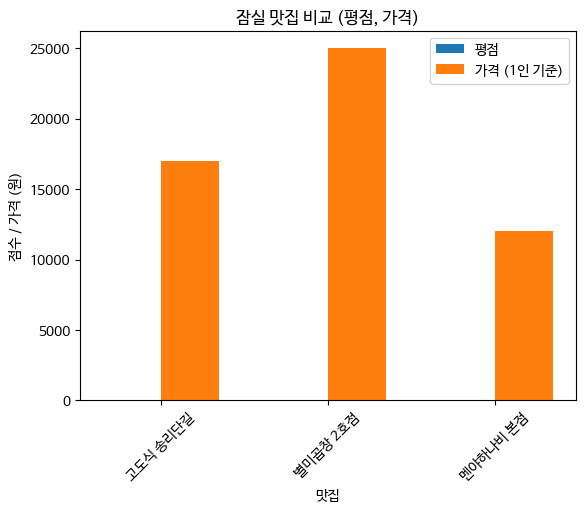

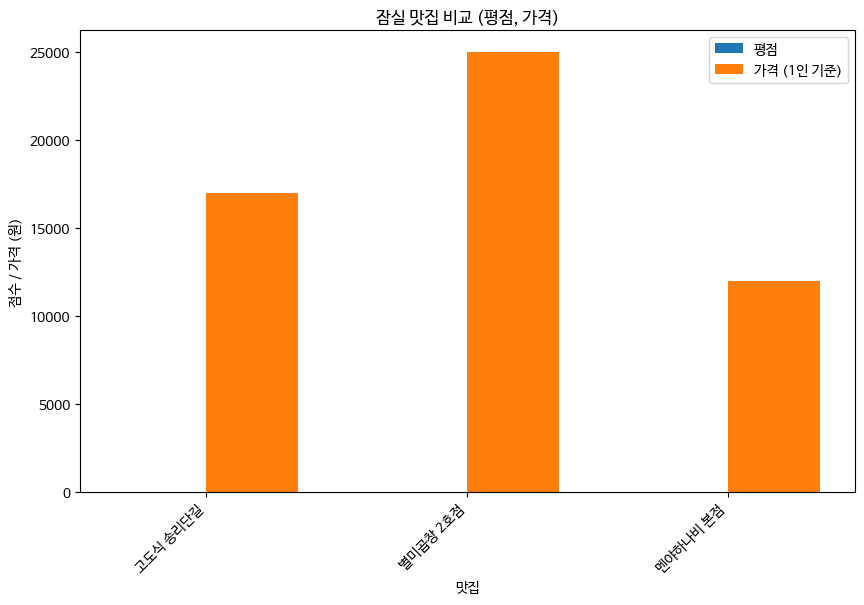

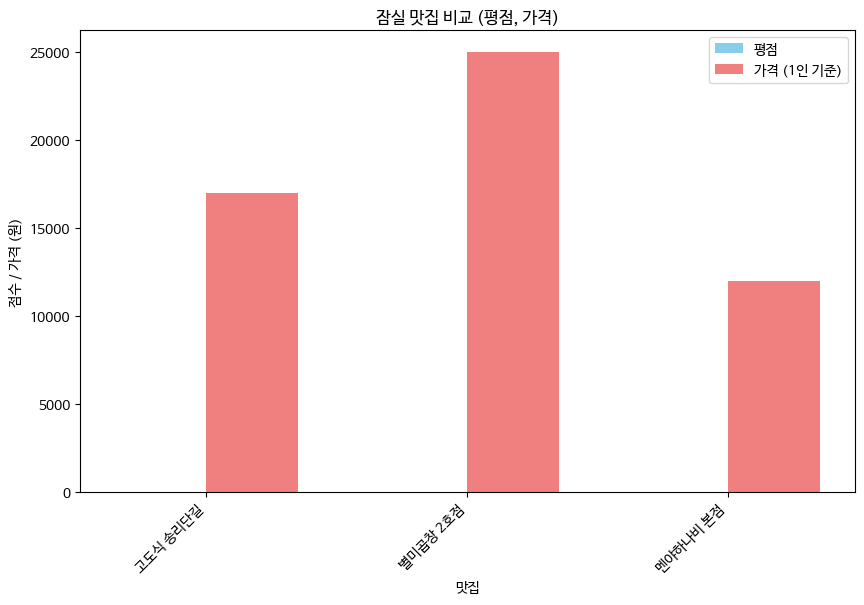

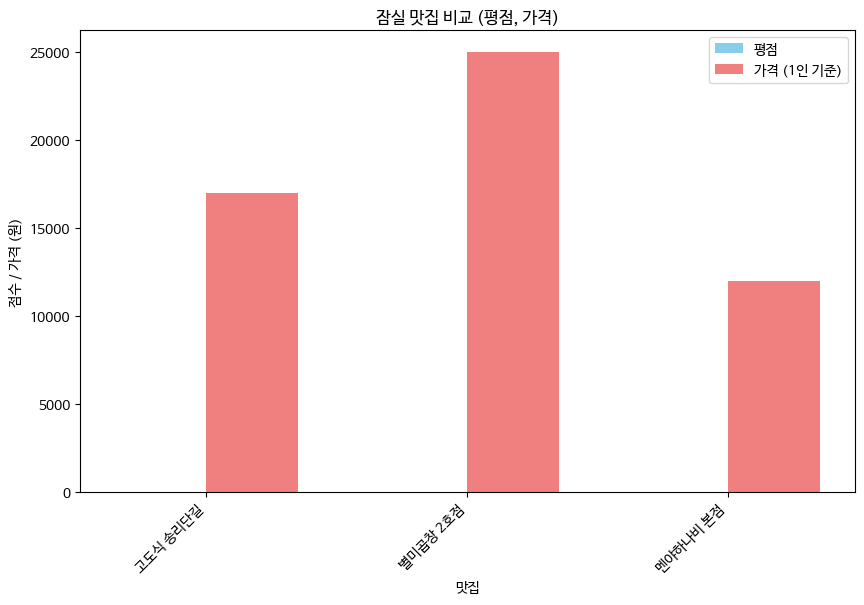

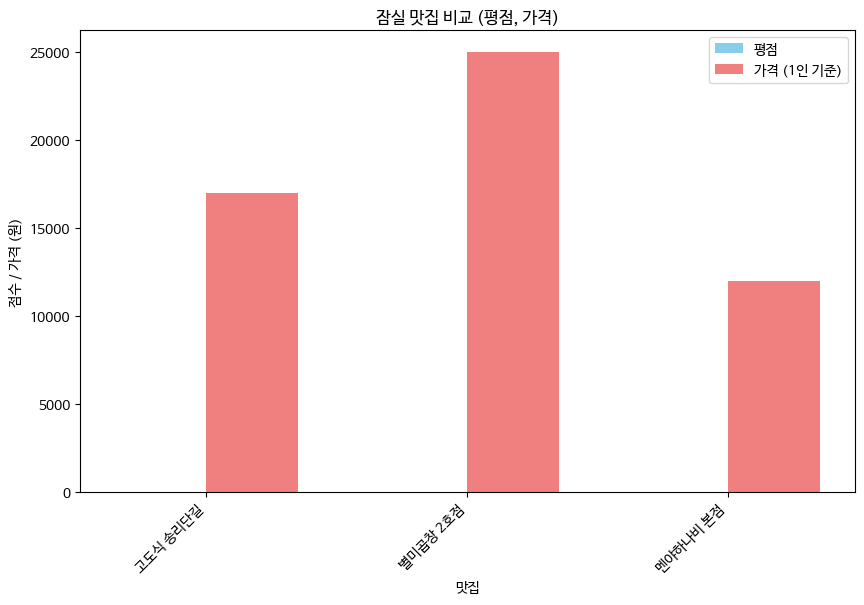

In [ ]:
events = graph.stream(
    {
        'next':'',
        "messages": [
            ("user","잠실역 맛집 3개 추천해줘.")
        ],
    },subgraphs=True,stream_mode='updates')



for s in events:
    for role in s:
        print(f'Role: {role}')
        print('')
        try:
            for message in s[role]['messages']:
                print(message.type,':', message.content)
        except:
            continue
        print('DEST:', s[role]['dest'])
        print('--------')
    #print(s)
    print("-------------")

##SUPERVISOR:  researcher --> 프로야구 순위 검색을 위해 researcher를 호출합니다. researcher는 필요한 정보를 검색하고 요약합니다
Role: ()

Role: {'supervisor': {'dest': 'researcher'}}

-------------
Role: ('researcher:600f79f9-ea1b-e3e7-4898-f6515464ce53',)

Role: {'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "2024 \\ud55c\\uad6d \\ud504\\ub85c\\uc57c\\uad6c \\ucd5c\\uc885 \\uc21c\\uc704"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-3fa995b4-fc66-4bb6-a3ed-5c57c80eb207-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '2024 한국 프로야구 최종 순위'}, 'id': 'b047f32c-14c1-4322-b629-2aa561453f66', 'type': 'tool_call'}], usage_metadata={'input_tokens': 177, 'output_tokens': 21, 'total_tokens': 198, 'input_token_details': {'cache_read': 0}})]}}

-------------
Role: ('researcher:600f79f9-ea1b-e3e7-4898-f6515464ce53',)


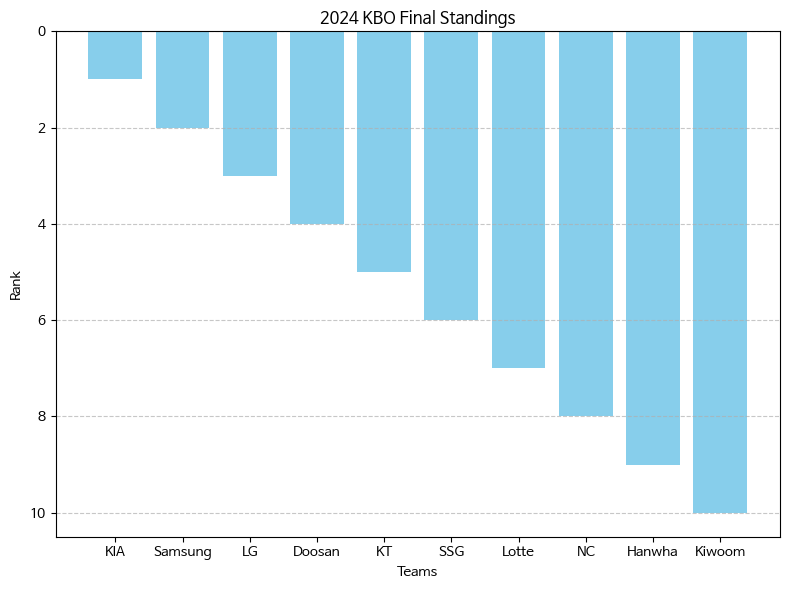

Role: ('chart_generator:ed056e63-1e1c-82f9-7bf2-a5122ef0fa61',)

Role: {'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'python_repl_tool', 'arguments': '{"code": "\\nimport matplotlib.pyplot as plt\\n\\nteams = [\\"KIA\\", \\"Samsung\\", \\"LG\\", \\"Doosan\\", \\"KT\\", \\"SSG\\", \\"Lotte\\", \\"NC\\", \\"Hanwha\\", \\"Kiwoom\\"]\\nranks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]\\n\\nplt.figure(figsize=(8, 6))  # Adjust figure size for better readability\\nplt.bar(teams, ranks, color=\\"skyblue\\")\\nplt.xlabel(\\"Teams\\")\\nplt.ylabel(\\"Rank\\")\\nplt.title(\\"2024 KBO Final Standings\\")\\nplt.gca().invert_yaxis()  # Invert y-axis to show rank 1 at the top\\nplt.grid(axis=\\"y\\", linestyle=\\"--\\", alpha=0.7)\\nplt.tight_layout()\\nplt.show()\\n"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-29e1081c-c701-4293-b4b1-6b31127b210f-0', tool_calls=[{'nam

In [ ]:
events = graph.stream(
    {
        'next':'',
        "messages": [
            ("user","2024년 한국 프로야구 10팀의 최종 순위 알려줘.")
        ],
    },subgraphs=True,stream_mode='updates')



for s in events:
    for role in s:
        print(f'Role: {role}')
        print('')
        try:
            for message in s[role]['messages']:
                print(message.type,':', message.content)
        except:
            continue
        print('DEST:', s[role]['dest'])
        print('--------')
    #print(s)
    print("-------------")

이와 같이 간단한 문제에 대해서는, Supervisor가 단순히 노드를 지정하는 것으로 해결할 수 있었습니다.   
만약 복잡한 Reasoning이 필요한 문제라면, Supervisor가 대화에 참여하는 것도 가능합니다.   

Langsmith (https://smith.langchain.com )에서 실행 결과를 확인할 수 있습니다.